# Parking Analysis Calculations

This file calculates parking stats for lots (everything besides street parking).

## Setup

[OSMnx](https://github.com/gboeing/osmnx) is used to download and maniuplate data from [OpenStreetMap](https://www.openstreetmap.org/#map=15/41.8222/-71.4085) (OSM).

In [5]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
from functools import reduce
from measurement.measures import Area
from decimal import Decimal
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11'

Specify the area to look for and the type of footprints to look for. Here, we only want the Downtown Neighborhood, and we are only looking for footprints tagged as "amenity:parking" in OSM.

**Note:** You must supply a `place` string which returns a valid result in OSM. For this calculation, I manually had to create the "Dowtown" neighborhood from the [City's GIS](http://pvdgis.maps.arcgis.com/home/webmap/viewer.html?useExisting=1&layers=07555d51a34a4fa0a43e9c920f68970f). Other neighborhoods may or may not be on OSM. For example, Fox Point and College Hill are, but Upper South Providence is not.

In [6]:
place = "Downtown, Providence, RI, USA"

Because of the way OSM stores data and OSMnx retrieves it, we need to handle street parking separately from how we handle parking in lots, whether they be surface, underground, or multi-level.

### Lot Parking

We will use OSMnx to download "footprints." These are effectively polygons representing the shapes of lots in the neighborhood. Each shape is "tagged" (in OSM parlance) with various bits of information (surface type, capacity, etc.).

For OSMnx to retrieve the right footprints, we need to specify a type:

In [7]:
footprint_type = "parking"

Download the footprints from OSM, and them project them to UTM 19 via OSMnx (UTM Zone selected automatically):

In [8]:
footprints_unprojected = ox.footprints.footprints_from_place(place, footprint_type=footprint_type)
footprints = ox.project_gdf(footprints_unprojected)

`footprints_from_place` and `project_gdf` returnn GeoPandas `GeoDataFrame`s. Examine the first few entries of the latter:

In [9]:
footprints.head()

,nodes,highway,name,oneway,parking,surface,geometry,lanes,tiger:cfcc,tiger:reviewed,...,description,fee,building:levels,lit,parking:lane:both,tiger:name_direction_prefix,smoothness,maxspeed,members,type
121498413,"[1359954107, 1359954080, 1359954126, 135995408...",NaN,Rhode Island Convention Center,NaN,multi-storey,NaN,"POLYGON ((299344.171 4633139.476, 299344.231 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535719,"[1549239929, 1549239995, 1549239920, 154923986...",NaN,Biltmore Garage,NaN,multi-storey,NaN,"POLYGON ((299480.300 4633065.483, 299518.656 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535724,"[1549239764, 3190088397, 1549239673, 154923959...",NaN,NaN,NaN,multi-storey,NaN,"POLYGON ((299920.958 4632965.162, 299927.951 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535769,"[1549239670, 7105448142, 7105448141, 154923954...",NaN,NaN,NaN,multi-storey,concrete:lanes,"POLYGON ((299345.605 4632950.568, 299388.869 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141535777,"[1549239863, 7107873191, 1549239787, 154923972...",NaN,NaN,NaN,multi-storey,NaN,"POLYGON ((299862.573 4633016.029, 299886.587 4...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And take a look at the geometries (stored as [Shapely Polygons](https://shapely.readthedocs.io/en/stable/manual.html#polygons)).

In [10]:
footprints.geometry.head()

121498413    POLYGON ((299344.171 4633139.476, 299344.231 4...
141535719    POLYGON ((299480.300 4633065.483, 299518.656 4...
141535724    POLYGON ((299920.958 4632965.162, 299927.951 4...
141535769    POLYGON ((299345.605 4632950.568, 299388.869 4...
141535777    POLYGON ((299862.573 4633016.029, 299886.587 4...
Name: geometry, dtype: geometry

And plot these as well, using OSMnx's `plot_footprints` function:

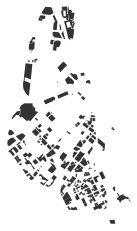

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127b442d0>)

In [11]:
ox.footprints.plot_footprints(footprints)

### Street Parking

Streets are defined as "ways" in OSM. Ideally, we would be able to pull these from OSM using the `osmnx.pois` module, but this is not currently possible because `osmnx.pois.create_poi_gdf` filters the dataset using the OSM `amenity` tag, which won't work since street parking is defined with the `parking:lane` tag. **Note:** [there is discussion](https://github.com/gboeing/osmnx/pull/342) on changing this in a future release of OSMnx.

Instead, we will get *all* OSM data as JSON, and filter to the ways we want.

First, we use `ox.gdf_from_place` to retrieve the geometry of the Downtown neighborhood:

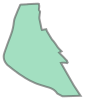

In [12]:
downtown_poly = ox.gdf_from_place("Downtown, Providence, RI, USA").geometry[0]
downtown_poly

Next, we extract the elements from this download, and filter:

In [13]:
download = ox.osm_net_download(polygon=downtown_poly)[0]['elements']

def is_way_with_parking(element):
    match_tags = ['parking:lane:both', 'parking:lane:left', 'parking:lane:right']
    
    val = element['type'] == 'way'
    val &= 'tags' in element and any(k in match_tags for k in element['tags'].keys())
    
    return val

filtered = list(filter(is_way_with_parking, download))

Next, we use a Pandas `DataFrame` to store useful values from that JSON.

**Note:** this is Pandas, not GeoPandas. Currently, we are not storing any geospatial information about the streets.

In [14]:
street_parking = pd.DataFrame()

for f in filtered:
        osmid = f['id']
        tags = f.get('tags', {})
        tags_to_copy = ['surface', 'highway', 'lanes', 'oneway', 'parking', 'name']
        for t in tags.keys():
            if any(t.startswith(c) for c in tags_to_copy):
                if t.endswith(":capacity"):
                    tags[t] = int(tags[t])
                street_parking.loc[osmid, t] = tags[t]

street_parking.head()

,highway,name,oneway,parking:lane:right,parking:lane:right:capacity,surface,parking:lane:both,parking:lane:both:capacity,parking:lane:left,parking:lane:left:capacity,lanes,lanes:backward,lanes:forward,parking:lane:left:parallel,parking:lane:right:parallel,name_1,parking:lane:both:parallel,parking,oneway:bicycle
19352934,residential,Abbott Park Place,yes,parallel,8.0,asphalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19357901,unclassified,Imperial Place,NaN,NaN,NaN,asphalt,parallel,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19357921,primary,Washington Place,yes,NaN,NaN,asphalt,NaN,NaN,parallel,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359927,unclassified,Exchange Street,NaN,NaN,NaN,asphalt,NaN,NaN,parallel,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359928,unclassified,Exchange Street,NaN,parallel,4.0,asphalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we filter out everything except the capacity columns... these are what we care about right now.

In [15]:
capacity_tags = ['parking:lane:right:capacity', 'parking:lane:left:capacity', 'parking:lane:both:capacity']
street_lane_capacities = street_parking[capacity_tags]
street_lane_capacities.head()

,parking:lane:right:capacity,parking:lane:left:capacity,parking:lane:both:capacity
19352934,8.0,NaN,NaN
19357901,NaN,NaN,10.0
19357921,NaN,6.0,NaN
19359927,NaN,4.0,NaN
19359928,4.0,NaN,NaN


Now, we sum horizontally:

In [16]:
street_capacities = pd.DataFrame()
street_capacities['total'] = street_lane_capacities.sum(axis=1)
street_capacities.head()

,total
19352934,8.0
19357901,10.0
19357921,6.0
19359927,4.0
19359928,4.0


And sum again to get the **total number of on-street parking spaces:**

In [17]:
int(street_capacities.sum()['total'])

2163

## Calculations

### Land use

First, we calculate the total area of the neighborhood. First, we must project the polygon from CRS to UTM, again via OSMnx. We then extract the area in square meters:

In [18]:
project_downtown_poly, _ = ox.project_geometry(downtown_poly)
downtown_area = project_downtown_poly.area

We'll do calculations in square meters for now, and then use this `convert_area` function to convert the area (via [python-measurement](https://github.com/coddingtonbear/python-measurement)) and round later on:

In [19]:
def convert_area(sq_meters, decimals=2):
    area_obj = Area(sq_m=sq_meters)
    return float(round(Decimal(area_obj.sq_mi), decimals))

convert_area(downtown_area)

0.78

Now, let's prepare a `GeoDataFrame` for land use calculations.

Start by getting the footprints of surface lots, joining them into a single shape with a GeoPandas `unary_union`, and saving the area into the frame:

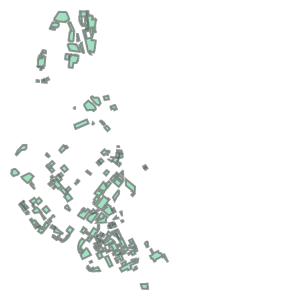

In [20]:
land_use = gpd.GeoDataFrame(columns=['geometry', 'area'])
land_use.set_geometry('geometry')

footprints_surface = footprints.query('parking=="surface"').geometry.unary_union
footprints_surface

In [21]:
land_use.loc['surface'] = [footprints_surface, footprints_surface.area]

*Notice:* Some of the larger lots like the Mall and Convention Center are now not shown, but there is a *lot* of small surface lots in the Jewelery District and a lot of large surface lots near the State House and State offices.

Do the same for structured parking (defined here as not surface):

In [22]:
footprints_structured = footprints.query('parking!="surface"').geometry.unary_union

land_use.loc['structured'] = [footprints_structured, footprints_structured.area]
land_use

,geometry,area
surface,"MULTIPOLYGON (((299329.815 4633865.645, 299339...",251808.353778
structured,"MULTIPOLYGON (((299647.813 4632190.896, 299717...",105105.131389


Now, let's calculate the percentage each type takes of all parking area, of total downtown area, and also convert to square miles:

In [36]:
land_use['area_square_miles'] = list(map(lambda x: Area(sq_m=x).sq_mi, land_use['area']))

In [46]:
total_parking_area = land_use['area'].sum()

calc_park_area_percent = lambda x: float(round(Decimal(x / total_parking_area) * 100, 2))
calc_downtown_area_percent = lambda x: float(round(Decimal(x / downtown_area) * 100, 2))

land_use['percent_parking_area'] = list(map(calc_park_area_percent, land_use['area']))
land_use['percent_downtown_area'] = list(map(calc_downtown_area_percent, land_use['area']))

In [47]:
land_use

,geometry,area,area_square_miles,percent_parking_area,percent_downtown_area
surface,"MULTIPOLYGON (((299329.815 4633865.645, 299339...",251808.353778,0.097224,70.55,12.48
structured,"MULTIPOLYGON (((299647.813 4632190.896, 299717...",105105.131389,0.040581,29.45,5.21


In [48]:
land_use.sum()

area                     356913.485166
area_square_miles             0.137805
percent_parking_area        100.000000
percent_downtown_area        17.690000
dtype: float64